In [1]:
from torchvision import datasets
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_folder = '/kaggle/working/'
fmnist = datasets.FashionMNIST(data_folder, download = True, train = True)
X = fmnist.data
Y = fmnist.targets

100%|██████████| 26421880/26421880 [00:02<00:00, 10338726.34it/s]


Extracting /kaggle/working/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 206590.27it/s]


Extracting /kaggle/working/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3931040.59it/s]


Extracting /kaggle/working/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 12883220.16it/s]

Extracting /kaggle/working/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/raw



In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)

In [4]:
type(y_test)

torch.Tensor

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
#função de ciração do dataset
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float()
        x = x.view(-1, 28*28)/255 # planificação com normalização
        self.x, self.y = x, y
    def __getitem__(self, ix):
        return self.x[ix].to(device), self.y[ix].to(device)
    def __len__(self):
        return len(self.x)

cuda


In [6]:
# função de criação do modelo
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000), # camada densa linear que recebe 784 valores e retorna 1000
        nn.ReLU(),
        nn.Linear(1000, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10) # 10 classes
    ).to(device)
    opt = Adam(model.parameters(), lr = 0.001)
    loss_fn = nn.CrossEntropyLoss()
    return model, opt, loss_fn

In [7]:
# função de treino de um batch
def train_batch(model, x, y, opt, loss_fn):
    model.train() # coloca o modelo em modo de treino
    predictions = model(x)
    batch_loss = loss_fn(predictions, y)
    batch_loss.backward() # backpropagation, pelo grafo computacional
    opt.step() # atualização dos pesos
    opt.zero_grad() # zera os gradientes para o próximo batch
    return batch_loss.item() # retorna o escalar no tensor batch_loss como python float

In [17]:
@torch.no_grad() # decorator que desativa o calculo dos gradientes para modelos pytorch no escopo da função seguinte
def accuracy(model, x, y):
    model.eval() # coloca o modelo no modo de validação
    predictions = model(x)
    max_values, argmaxes = predictions.max(-1) # pega os maiores valores (prob) de cada previsão e seus índices
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [25]:
@torch.no_grad()
def val_loss(model, x, y):
    predictions = model(x)
    val_loss = loss_fn(predictions, y)
    return val_loss.item()

In [18]:
# função que cria o dataset e o dataloader, retorna o dataloader
def get_data():
    train_ds = FMNISTDataset(X_train, y_train)
    test_ds = FMNISTDataset(X_test, y_test)
    train_dl = DataLoader(train_ds, batch_size = 32, shuffle = True)
    test_dl = DataLoader(test_ds, batch_size = len(X_test), shuffle = False)
    return train_dl, test_dl

In [30]:
train_dl, test_dl = get_data()
model, opt, loss_fn = get_model()

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [32]:
# loop de treinamento de avaliação
train_losses, train_accs = [], []
val_losses, val_accs = [], []
for epoch in range(5):
    print(epoch)
    train_epoch_losses, train_epoch_accs = [], []
    for batch in iter(train_dl):
        x, y = batch
        batch_loss = train_batch(model, x, y, opt, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for batch in iter(train_dl):
        x, y = batch
        is_correct = accuracy(model, x, y)
        train_epoch_accs.extend(is_correct)
    train_epoch_acc = np.mean(train_epoch_accs)
    
    for batch in iter(test_dl):
        x, y = batch
        val_is_correct = accuracy(model, x, y)
        validation_loss = val_loss(model, x, y)
    val_epoch_acc = np.mean(val_is_correct)
    
    train_losses.append(train_epoch_loss)
    train_accs.append(train_epoch_acc)
    val_losses.append(validation_loss)
    val_accs.append(val_epoch_acc)

0
1
2
3
4


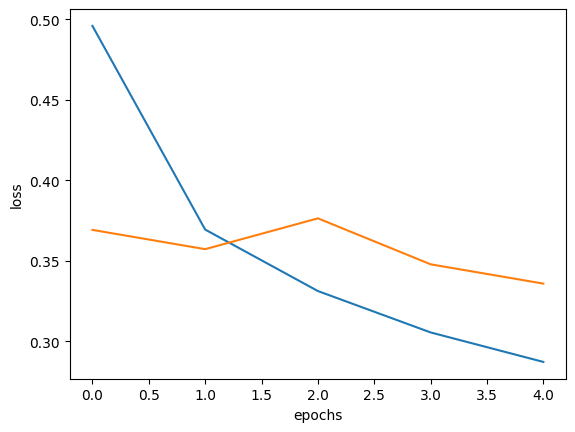

In [33]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

Text(0, 0.5, 'accuracies')

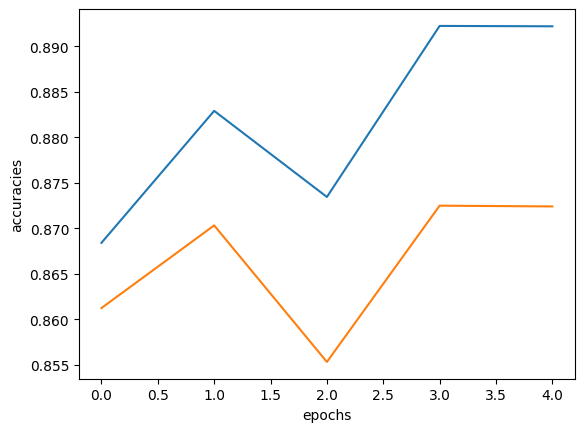

In [34]:
plt.plot(train_accs)
plt.plot(val_accs)
plt.xlabel('epochs')
plt.ylabel('accuracies')